In [1]:
cd ../src

/Users/anton_shevchuk_air/Documents/code/talk-to-data/src


/Users/anton_shevchuk_air/Library/Caches/pypoetry/virtualenvs/hachathon-AYAZCC8L-py3.12/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
from typing import List

from langchain_aws import ChatBedrock
from langchain_core.messages import HumanMessage
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import create_react_agent
from langchain_core.tools import tool

import matplotlib.pyplot as plt
import pandas as pd

# from tools import fraud_classifier, query_financial_df

# Tools

In [3]:
from typing import List
import pandasql as ps
import random
from langchain_core.tools import tool
import logging
import pandas as pd
import joblib
from model import preprocess_data 

# Setup logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')


@tool(parse_docstring=True)
def show_column_distribution(column: str) -> pd.Series:
    """
    Print image of the column distribution of the financial DataFrame

    Args:
        column: Column name in the financial DataFrame.
    """
    global df
    plot = df[column].value_counts().plot(kind='bar')
    plot.get_figure()


@tool(parse_docstring=True)
def classify_fraud(query: str):
    """
    Classify rows of the df whether they are fraud or not.

    Args:
        query: SQL query string to execute on the DataFrame to obtain df rows to classify
    """
    input_df = ps.sqldf(query)

    # Load the saved model and pre-processing objects from the disk
    logging.info("Loading model and pre-processing pipeline from: %s")
    loaded_objects = joblib.load("rf_model_pipeline_compressed.pkl")
    loaded_model = loaded_objects['model']
    loaded_onehot_encoder = loaded_objects['onehot_encoder']
    loaded_scaler = loaded_objects['scaler']

    # Drop any columns that were not used in the model training
    logging.info("Dropping columns that were not used in training.")
    input_df = input_df.drop(['device_fraud_count', 'fraud_bool'], axis=1, errors='ignore')

    # Apply the same pre-processing to the input data
    logging.info("Applying pre-processing to the input data.")
    X_preprocessed, _, _ = preprocess_data(input_df, onehot_encoder=loaded_onehot_encoder, scaler=loaded_scaler, is_train=False)

    # Make predictions using the loaded model
    logging.info("Making predictions.")
    predictions = loaded_model.predict(X_preprocessed)

    return predictions

    
@tool(parse_docstring=True)
def query_financial_df(query: str):
    """
    Queries the financial DataFrame using SQL-like syntax.
    The DataFrame contains the following columns:
        fraud_bool (int64): Indicator of fraud.
        income (float64): Reported income.
        name_email_similarity (float64): Similarity between name and email.
        prev_address_months_count (int64): Months at the previous address.
        current_address_months_count (int64): Months at the current address.
        customer_age (int64): Age of the customer.
        days_since_request (float64): Days since the request.
        intended_balcon_amount (float64): Intended balance amount.
        payment_type (object): Type of payment.
        zip_count_4w (int64): Zip code count in the last 4 weeks.
        velocity_6h (float64): Transaction velocity in the last 6 hours.
        velocity_24h (float64): Transaction velocity in the last 24 hours.
        velocity_4w (float64): Transaction velocity in the last 4 weeks.
        bank_branch_count_8w (int64): Bank branch count in the last 8 weeks.
        date_of_birth_distinct_emails_4w (int64): Number of distinct emails in the last 4 weeks related to date of birth.
        employment_status (object): Employment status of the customer.
        credit_risk_score (int64): Credit risk score of the customer.
        email_is_free (int64): Indicator if the email is from a free provider.
        housing_status (object): Housing status of the customer.
        phone_home_valid (int64): Indicator if the home phone is valid.
        phone_mobile_valid (int64): Indicator if the mobile phone is valid.
        bank_months_count (int64): Months with the bank.
        has_other_cards (int64): Indicator if the customer has other cards.
        proposed_credit_limit (float64): Proposed credit limit.
        foreign_request (int64): Indicator if the request is foreign.
        source (object): Source of the request.
        session_length_in_minutes (float64): Length of the session in minutes.
        device_os (object): Operating system of the device.
        keep_alive_session (int64): Indicator if the session is kept alive.
        device_distinct_emails_8w (int64): Distinct emails on the device in the last 8 weeks.
        device_fraud_count (int64): Fraud count associated with the device.
        month (int64): Month of the request.
    Example queries:
        SELECT * FROM df WHERE income > 0.2
        SELECT * FROM df ORDER BY "index" DESC LIMIT 10

    Args:
        query: SQL query string to execute on the DataFrame.
    """
    res_df = ps.sqldf(query)
    return res_df if len(res_df) < 10 else res_df.head(10)

# Data

In [4]:
df = pd.read_csv('s3://hackathon.datasets/Bank Account Fraud Dataset Suite/Base.csv', nrows=100)

2024-10-07 17:59:47,751 - INFO - Found credentials in shared credentials file: ~/.aws/credentials


In [5]:
df.head()

,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,zip_count_4w,...,has_other_cards,proposed_credit_limit,foreign_request,source,session_length_in_minutes,device_os,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month
0,0,0.3,0.986506,-1,25,40,0.006735,102.453711,AA,1059,...,0,1500.0,0,INTERNET,16.224843,linux,1,1,0,0
1,0,0.8,0.617426,-1,89,20,0.010095,-0.849551,AD,1658,...,0,1500.0,0,INTERNET,3.363854,other,1,1,0,0
2,0,0.8,0.996707,9,14,40,0.012316,-1.490386,AB,1095,...,0,200.0,0,INTERNET,22.730559,windows,0,1,0,0
3,0,0.6,0.475100,11,14,30,0.006991,-1.863101,AB,3483,...,0,200.0,0,INTERNET,15.215816,linux,1,1,0,0
4,0,0.9,0.842307,-1,29,40,5.742626,47.152498,AA,2339,...,0,200.0,0,INTERNET,3.743048,other,0,1,0,0


In [6]:
ps.sqldf("SELECT * FROM df WHERE income > 0.2")

,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,zip_count_4w,...,has_other_cards,proposed_credit_limit,foreign_request,source,session_length_in_minutes,device_os,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month
0,0,0.3,0.986506,-1,25,40,0.006735,102.453711,AA,1059,...,0,1500.0,0,INTERNET,16.224843,linux,1,1,0,0
1,0,0.8,0.617426,-1,89,20,0.010095,-0.849551,AD,1658,...,0,1500.0,0,INTERNET,3.363854,other,1,1,0,0
2,0,0.8,0.996707,9,14,40,0.012316,-1.490386,AB,1095,...,0,200.0,0,INTERNET,22.730559,windows,0,1,0,0
3,0,0.6,0.475100,11,14,30,0.006991,-1.863101,AB,3483,...,0,200.0,0,INTERNET,15.215816,linux,1,1,0,0
4,0,0.9,0.842307,-1,29,40,5.742626,47.152498,AA,2339,...,0,200.0,0,INTERNET,3.743048,other,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,0,0.3,0.440218,-1,102,20,15.369665,18.624725,AA,2080,...,0,200.0,0,INTERNET,7.086092,other,1,1,0,0
76,0,0.9,0.904023,-1,13,20,0.016013,-1.183363,AD,1598,...,0,200.0,0,INTERNET,8.426955,other,1,1,0,0
77,0,0.3,0.216222,99,2,30,0.006087,-0.840237,AC,998,...,0,200.0,0,INTERNET,24.585407,other,1,1,0,0
78,0,0.6,0.746487,-1,91,50,0.011544,-1.138653,AC,5139,...,0,1000.0,0,INTERNET,19.435168,other,1,1,0,0


In [7]:
query_financial_df("SELECT * FROM df ORDER BY 'index' DESC LIMIT 10")

/var/folders/87/5x_pzvw515x1ch3g128f5xj00000gn/T/ipykernel_56529/3395251940.py:1: LangChainDeprecationWarning: The method `BaseTool.__call__` was deprecated in langchain-core 0.1.47 and will be removed in 1.0. Use :meth:`~invoke` instead.
  query_financial_df("SELECT * FROM df ORDER BY 'index' DESC LIMIT 10")


,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,zip_count_4w,...,has_other_cards,proposed_credit_limit,foreign_request,source,session_length_in_minutes,device_os,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month
0,0,0.3,0.986506,-1,25,40,0.006735,102.453711,AA,1059,...,0,1500.0,0,INTERNET,16.224843,linux,1,1,0,0
1,0,0.8,0.617426,-1,89,20,0.010095,-0.849551,AD,1658,...,0,1500.0,0,INTERNET,3.363854,other,1,1,0,0
2,0,0.8,0.996707,9,14,40,0.012316,-1.490386,AB,1095,...,0,200.0,0,INTERNET,22.730559,windows,0,1,0,0
3,0,0.6,0.475100,11,14,30,0.006991,-1.863101,AB,3483,...,0,200.0,0,INTERNET,15.215816,linux,1,1,0,0
4,0,0.9,0.842307,-1,29,40,5.742626,47.152498,AA,2339,...,0,200.0,0,INTERNET,3.743048,other,0,1,0,0
5,0,0.6,0.294840,-1,369,30,0.024232,-1.232556,AD,1204,...,0,200.0,0,INTERNET,6.987316,linux,1,1,0,0
6,0,0.2,0.773085,22,4,40,0.006919,-0.544676,AB,1998,...,0,200.0,0,INTERNET,28.199923,x11,1,1,0,0
7,0,0.8,0.153880,-1,103,40,0.045122,-1.101184,AB,1548,...,1,200.0,0,INTERNET,11.234264,other,1,1,0,0
8,0,0.3,0.523655,21,2,30,0.035206,-0.955737,AB,1781,...,0,200.0,0,INTERNET,5.329387,other,1,1,0,0
9,0,0.8,0.834475,-1,134,20,0.017245,-1.356393,AD,3113,...,0,1500.0,0,INTERNET,4.103970,other,1,1,0,0


In [8]:
classify_fraud("SELECT * FROM df WHERE income > 0.2")

2024-10-07 17:59:55,851 - INFO - Loading model and pre-processing pipeline from: %s
2024-10-07 17:59:56,321 - INFO - Dropping columns that were not used in training.
2024-10-07 17:59:56,328 - INFO - Applying pre-processing to the input data.
2024-10-07 17:59:56,337 - INFO - Making predictions.


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

## Model

In [9]:
model = ChatBedrock(
    model_id="anthropic.claude-3-sonnet-20240229-v1:0",
    model_kwargs=dict(temperature=0),
)

2024-10-07 18:00:05,420 - INFO - Found credentials in shared credentials file: ~/.aws/credentials


In [10]:
memory = MemorySaver()
tools = [query_financial_df, classify_fraud, show_column_distribution]
agent_executor = create_react_agent(model, tools, checkpointer=memory)

{'agent': {'messages': [AIMessage(content='', additional_kwargs={'usage': {'prompt_tokens': 1860, 'completion_tokens': 88, 'total_tokens': 1948}, 'stop_reason': 'tool_use', 'model_id': 'anthropic.claude-3-sonnet-20240229-v1:0'}, response_metadata={'usage': {'prompt_tokens': 1860, 'completion_tokens': 88, 'total_tokens': 1948}, 'stop_reason': 'tool_use', 'model_id': 'anthropic.claude-3-sonnet-20240229-v1:0'}, id='run-608e5766-9055-47e6-a03d-d1b0b05e0bae-0', tool_calls=[{'name': 'show_column_distribution', 'args': {'column': 'device_os'}, 'id': 'toolu_bdrk_01EDxK62VGxRvYZ9NsHytooz', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1860, 'output_tokens': 88, 'total_tokens': 1948})]}}
----
{'tools': {'messages': [ToolMessage(content='null', name='show_column_distribution', id='ee166eba-8fca-456b-9634-cfa0a7cafa40', tool_call_id='toolu_bdrk_01EDxK62VGxRvYZ9NsHytooz')]}}
----
{'agent': {'messages': [AIMessage(content="The show_column_distribution tool prints an image showing the distri

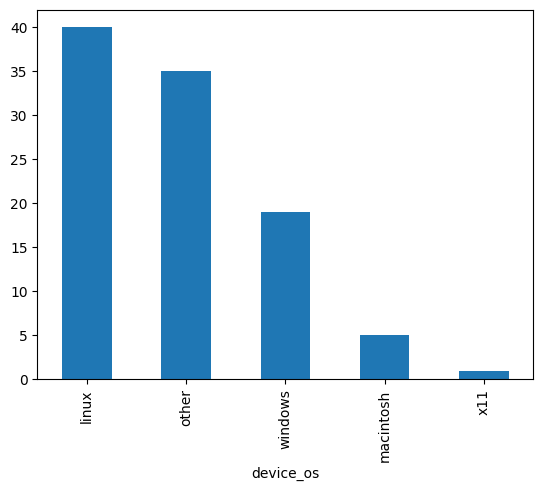

In [12]:
# question = "what is the max income?"
# question = "what is the minimum income?"
# question = "what is the avg income?"
# question = "what is total number of fraud users?"
# question = "what are the payment types that are available?"
# question = "what is the num of fraud users in each payment type category?"
# question = "What is the average session length for customers using Linux and Windows devices?"
# question = "Show me all accounts where the fraud score is above 0.8 and the customer has made more than three transactions in the last 6 hours?"
# question = "Which customers have a credit risk score above 150 but have less than six months with the bank?"
# question = "classify last 5 rows of the df whether they are fraud or not"
# question = "get last 5 rows of the df and five shape of the resulting df"
# question = "classify last 5 rows of data whether they are fraud or not"
question = "show distribution of devices used by customers"


for chunk in agent_executor.stream(
    {"messages": [HumanMessage(content=question)]}, config={"configurable": {"thread_id": 42}}
):
    print(chunk)
    print("----")